In [2]:
# partially complete. 
import os
import h5py
import pandas as pd

In [44]:
print(os.listdir("data/nextVQA"))
annotations_pth = "data/nextVQA/train.csv"
videos_root_dir = "data/videos/"
videos_dir = "nextVQA/"

df = pd.read_csv(annotations_pth)
# https://github.com/doc-doc/NExT-QA/blob/8f193602eda16acf3f4c6f7d4b7e8c6969b99951/eval_mc.py#L4
map_name = {'CW': 'Why', 'CH': 'How', 'TN': 'Bef&Aft', 'TC': 'When', 'DC': 'Cnt', 'DL': 'Loc', 'DO': 'Other', 'C': 'Acc_C', 'T': 'Acc_T', 'D': 'Acc_D'}
# sort by length of question
df['len'] = df['question'].apply(lambda x: len(x.split()))
df['type'] = df['type'].map(map_name)
df.head()

['train.csv', 'nextqa_gdriveids.txt', 'val.csv', 'map_vid_vidorID.json', 'vocab.pkl']


,video,frame_count,width,height,question,answer,qid,type,a0,a1,a2,a3,a4,len
0,3238737531,2303,640,480,how many children are in the video,3,2,Cnt,one,three,seven,two,five,7
1,8968804598,332,640,360,why is the blue sweater guy looking at the shi...,4,0,Why,sharing with his friends,found the man funny,poor vision,keep hands warm,training,11
2,13884124143,853,640,360,how did the guy on the board managed to not fa...,4,1,How,jump,nod,push the chair away,playing the piano,move left right to balance,21
3,2617504308,1218,500,281,why does the man have to throw the plane first...,3,3,Why,chase the ball,the toy car hit the wall,put on earmuffs,get it start flying,bounce baby on cushion,16
4,10521491465,1735,640,360,why is the panda on the grass brown,1,4,Why,to sit up,dirty,prevent it from escaping,get dirt off,resting and eating,8


['Cnt' 'Why' 'How' 'Bef&Aft' 'When' 'Loc' 'Other' nan]


<AxesSubplot: >

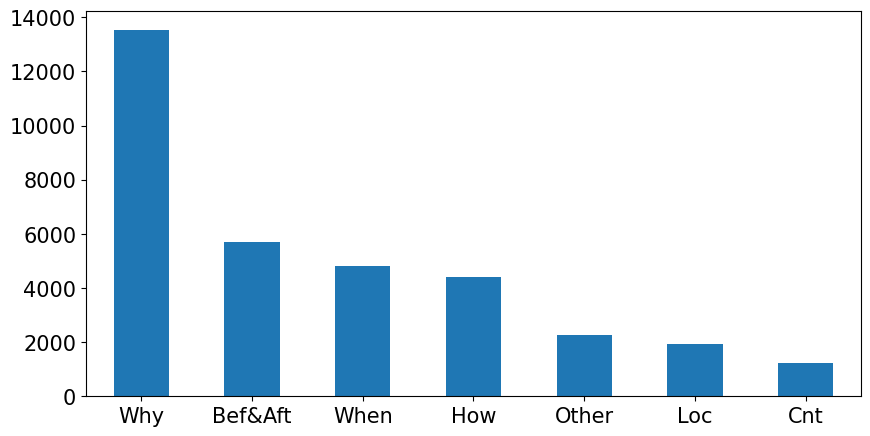

In [45]:

print(df['type'].unique())

df['type'].value_counts().plot(kind='bar', figsize=(10, 5), rot=0, fontsize=15)

In [46]:
df.groupby('type')['type', 'question'].sample(3).values

/tmp/ipykernel_154552/2392257980.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('type')['type', 'question'].sample(3).values


array([['Bef&Aft',
        'what did the baby do after sitting on the floor for a while at the end of the video'],
       ['Bef&Aft',
        'what does the boy do after approaching the chair at the start'],
       ['Bef&Aft',
        'what did the dog do after looking through the window at the end'],
       ['Cnt', 'how many people are in the video'],
       ['Cnt', 'how many meerkats were filmed at the start'],
       ['Cnt', 'how many children are there in the video'],
       ['How',
        'how does the boy direct the lady s attention towards the phone'],
       ['How', 'how were the arms of the baby moved by the man'],
       ['How', 'how does the man in white play his game'],
       ['Loc', 'where is the video taken'],
       ['Loc', 'where are the boys hanging out'],
       ['Loc', 'where are the men hanging out'],
       ['Other',
        'what is the relationship between the two kids and the man with shirt'],
       ['Other', 'who is present int the video'],
       ['Other',


In [48]:
import json
with open('data/nextVQA/map_vid_vidorID.json', 'r') as f:
    map_vid_vidorID = json.load(f)
print(list(map_vid_vidorID.items())[:5])

[('2909445186', '0101/2909445186'), ('3837320324', '0016/3837320324'), ('3161384320', '0094/3161384320'), ('8615395280', '1200/8615395280'), ('8129290253', '1027/8129290253')]


In [49]:
localize_questions_only = df[df['type'] == 'Loc']

def transform_to_viper_fmt(df):
    """
    Viper Format:
        index:
        sample_id:
        possible_answers: 
        query_type:
        query:
        answer: Actual correct answer.
        video_name:
    """
    root_dir = "data/videos/"
    viper_df = df.copy()
    viper_df['possible_answers'] = df[['a0', 'a1', 'a2', 'a3', 'a4']].apply(lambda x: ' '.join(x), axis=1)
    viper_df['query_type'] = ''
    viper_df['sample_id'] = df.index
    viper_df['query'] = df['question'].str.capitalize() + '?'
    viper_df['answer'] = df.apply(lambda row : row['a' + str(row['answer'])], axis=1)
    viper_df['video_name'] = df['video'].astype(str).map(map_vid_vidorID).apply(lambda x: os.path.join(videos_dir, x) + '.mp4')    
    for pth in viper_df['video_name'].values:
        pth = os.path.exists(root_dir + pth)
        assert pth, f"Video path {pth} does not exist"
    return viper_df[['sample_id', 'possible_answers', 'query_type', 'query', 'answer', 'video_name']].reset_index(drop=False).sort_values(by='index')

viper_fmt_df = transform_to_viper_fmt(localize_questions_only)
viper_fmt_df.describe()

,index,sample_id
count,1942.000000,1942.000000
mean,17278.380536,17278.380536
std,9744.088328,9744.088328
min,14.000000,14.000000
25%,9102.500000,9102.500000
50%,17324.000000,17324.000000
75%,25630.250000,25630.250000
max,34093.000000,34093.000000


In [20]:
viper_fmt_df.head(10).to_csv('data/nextVQA_queries.csv', index=False)

In [ ]:
# Run
# Cost: 0.05 USD with gpt3.5turbo
# CUDA_VISIBLE_DEVICES=0 CONFIG_NAMES=NextVQA_video_config python main_batch.py

In [25]:
pd.read_csv("results/results_17.csv")

,result,answer,code,id,query,img_path,possible_answers
0,\n\nThe location of a building depends on the ...,house,"def execute_command_14(video, possible_answers...",14,Where is this video taken?,data/videos/nextVQA/1120/3229982634.mp4,house kitchen stage ballroom train
1,\n\nSt. Peter's Church is located in the Vatic...,road,"def execute_command_20(video, possible_answers...",20,Where is this video taken?,data/videos/nextVQA/1005/6217597005.mp4,playground sea zoo boxing ring road
2,\n\nSt. Peter's Church is located in the Vatic...,garden,"def execute_command_34(video, possible_answers...",34,Where is this video taken?,data/videos/nextVQA/1024/9337790459.mp4,garden field dinning table along the streets lake
3,the wall,screen,"def execute_command_40(video, possible_answers...",40,Where is the boy projecting his photos on?,data/videos/nextVQA/1165/7843288978.mp4,wall table beach floor screen
4,None,house,"def execute_command_63(video, possible_answers...",63,Where is this place?,data/videos/nextVQA/1014/3552516882.mp4,bus terminal outdoors kitchen house waterfall
5,None,kitchen,"def execute_command_96(video, possible_answers...",96,Where is this happening?,data/videos/nextVQA/0046/2399344595.mp4,karaoke room hiking trail kitchen cycling trai...
6,None,near a lake,"def execute_command_112(video, possible_answer...",112,Where is this happening?,data/videos/nextVQA/1006/2782675613.mp4,near a lake outdoor in the sea river trail
7,None,classroom,"def execute_command_122(video, possible_answer...",122,Where are the people attending the event?,data/videos/nextVQA/1002/6096540713.mp4,dance hall office grassland bedroom classroom
8,None,outside the house,"def execute_command_143(video, possible_answer...",143,Where could this be happening?,data/videos/nextVQA/0101/2909445186.mp4,garden living room farm shop outside the house
9,None,kitchen,"def execute_command_150(video, possible_answer...",150,Where is this happening?,data/videos/nextVQA/1001/6512025357.mp4,classroom roadside kitchen by a lake work place


##Errors
```python
  0%|                                                                                               | 0/1 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_63
    import os
NameError: name 'image' is not defined
Sample 63 failed with error: name 'image' is not defined. Next you will see an "expected an indented block" error. 
Sample 63 failed at compilation time with error: expected an indented block after function definition on line 1 (Codex, line 2)
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_63
    import os
NameError: name 'image' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_63
    import os
NameError: name 'image' is not defined
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_96
    import os
NameError: name 'image' is not defined
Sample 96 failed with error: name 'image' is not defined. Next you will see an "expected an indented block" error. 
Sample 96 failed at compilation time with error: expected an indented block after function definition on line 1 (Codex, line 2)
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_96
    import os
NameError: name 'image' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_96
    import os
NameError: name 'image' is not defined
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_112
    import os
NameError: name 'image' is not defined
Sample 112 failed with error: name 'image' is not defined. Next you will see an "expected an indented block" error. 
Sample 112 failed at compilation time with error: expected an indented block after function definition on line 1 (Codex, line 2)
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_112
    import os
NameError: name 'image' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_112
    import os
NameError: name 'image' is not defined
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 4, in execute_command_122
    import pathlib
AttributeError: 'generator' object has no attribute 'find'
Sample 122 failed with error: 'generator' object has no attribute 'find'. Next you will see an "expected an indented block" error. 
Sample 122 failed at compilation time with error: expected an indented block after function definition on line 1 (Codex, line 2)
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 4, in execute_command_122
    import pathlib
AttributeError: 'generator' object has no attribute 'find'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_122
    import os
NameError: name 'image' is not defined
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_143
    import os
NameError: name 'image' is not defined
Sample 143 failed with error: name 'image' is not defined. Next you will see an "expected an indented block" error. 
Sample 143 failed at compilation time with error: expected an indented block after function definition on line 1 (Codex, line 2)
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_143
    import os
NameError: name 'image' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_143
    import os
NameError: name 'image' is not defined
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_150
    import os
NameError: name 'image' is not defined
Sample 150 failed with error: name 'image' is not defined. Next you will see an "expected an indented block" error. 
Sample 150 failed at compilation time with error: expected an indented block after function definition on line 1 (Codex, line 2)
Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_150
    import os
NameError: name 'image' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/asehgal/viper/main_batch.py", line 76, in run_program
    result = globals()[f'execute_command_{sample_id}'](
  File "Codex", line 3, in execute_command_150
    import os
NameError: name 'image' is not defined
```

In [57]:
debug_df = pd.read_csv("results/results_17.csv")
def pprint_results_df(debug_df):
    for i in range(len(debug_df)):
        print(f"QUESTION_{i}: {debug_df['query'][i]}")
        print(f"ANSWER_{i}: {debug_df['answer'][i]}")
        print(f"RESULT_{i}: {debug_df['result'][i].strip() }")
        print("=" * 80)
        print(f"CODEBLOCK_{i}")
        print(debug_df['code'][i])
        print("=" * 80)
    
pprint_results_df(debug_df)

QUESTION_0: Where is this video taken?
ANSWER_0: house
RESULT_0: The location of a building depends on the specific building in question.
CODEBLOCK_0
def execute_command_14(video, possible_answers, query, ImagePatch, VideoSegment, llm_query, bool_to_yesno, distance, best_image_match):
    # Answer is:def execute_command(video):
    video_segment = VideoSegment(video)
    building_patches = video_segment.frame_iterator()
    for frame in building_patches:
        building_name = frame.simple_query("What is the name of the building?")
        location = frame.llm_query(f"Where is {building_name} located?")
        if location:
            return location
    return "Location not found"
QUESTION_1: Where is this video taken?
ANSWER_1: road
RESULT_1: St. Peter's Church is located in the Vatican City, Rome, Italy.
CODEBLOCK_1
def execute_command_20(video, possible_answers, query, ImagePatch, VideoSegment, llm_query, bool_to_yesno, distance, best_image_match):
    # Answer is:def execute_com

In [51]:
# sort viper_fmt_df by length of query
viper_fmt_df['query_length'] = viper_fmt_df['query'].apply(lambda x: len(x.split()))
viper_fmt_df = viper_fmt_df.sort_values(by=['query_length'], ascending=False).drop(columns=['query_length'])
viper_fmt_df.head(10)

,index,sample_id,possible_answers,query_type,query,answer,video_name
1412,24647,24647,table the lady with white blanket dining table...,,Where did the girl go after she left the windo...,sink area in kitchen,nextVQA/1021/5757232720.mp4
1819,32161,32161,elbow neck head eyes shoulder,,Where did the man with blue gloves defend with...,head,nextVQA/1023/6359353825.mp4
879,15883,15883,at a house outdoors tree head bench,,Where was the boy in stripped shirt holding to...,bench,nextVQA/0027/2530259622.mp4
279,5299,5299,airport desert left out of the gate road food ...,,Where did the car turn when it reached the end...,left out of the gate,nextVQA/1000/5211085354.mp4
1063,18932,18932,by the window in the air neighbourhood in the ...,,Where did the man in purple put the boy in str...,in the room,nextVQA/0076/2615323477.mp4
101,2105,2105,living room the side of the pool the lady fish...,,Where are the man in the water and the boy wit...,the side of the pool,nextVQA/1007/3557607884.mp4
1743,30578,30578,beach room on man s shoulder adult's lap on th...,,Where did the boy in blue rest his head when t...,on man s shoulder,nextVQA/1103/3577736291.mp4
743,13514,13514,grass patch living room beach kitchen water park,,Where is this place in the house that the peop...,living room,nextVQA/1008/5585306763.mp4
1751,30735,30735,at home table prevent falling living room toilet,,Where is there two green ropes supporting the ...,prevent falling,nextVQA/0095/7501179714.mp4
740,13471,13471,on water bedroom forest behind the lady outdoors,,Where is this place in the room where the man ...,outdoors,nextVQA/1007/2632387219.mp4


In [54]:
viper_fmt_df.head(10).to_csv('data/nextVQA_queries.csv', index=False)

In [55]:
!CUDA_VISIBLE_DEVICES=0 CONFIG_NAMES=NextVQA_video_config python main_batch.py


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/asehgal/envs/envs/vipergpt/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so
/home/asehgal/envs/envs/vipergpt/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/asehgal/envs/envs/vipergpt/lib/libcudart.so'), PosixPath('/home/asehgal/envs/envs/vipergpt/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libc

In [56]:
pd.read_csv("results/results_18.csv")

,result,answer,code,id,query,img_path,possible_answers
0,The girl is in the middle of the living room,sink area in kitchen,"def execute_command_24647(video, possible_answ...",24647,Where did the girl go after she left the windo...,data/videos/nextVQA/1021/5757232720.mp4,table the lady with white blanket dining table...
1,None,head,"def execute_command_32161(video, possible_answ...",32161,Where did the man with blue gloves defend with...,data/videos/nextVQA/1023/6359353825.mp4,elbow neck head eyes shoulder
2,\n\nThe boy was holding onto a railing to bala...,bench,"def execute_command_15883(video, possible_answ...",15883,Where was the boy in stripped shirt holding to...,data/videos/nextVQA/0027/2530259622.mp4,at a house outdoors tree head bench
3,None,left out of the gate,"def execute_command_5299(video, possible_answe...",5299,Where did the car turn when it reached the end...,data/videos/nextVQA/1000/5211085354.mp4,airport desert left out of the gate road food ...
4,None,in the room,"def execute_command_18932(video, possible_answ...",18932,Where did the man in purple put the boy in str...,data/videos/nextVQA/0076/2615323477.mp4,by the window in the air neighbourhood in the ...
5,They are heading to the right.,the side of the pool,"def execute_command_2105(video, possible_answe...",2105,Where are the man in the water and the boy wit...,data/videos/nextVQA/1007/3557607884.mp4,living room the side of the pool the lady fish...
6,On the man's shoulder,on man s shoulder,"def execute_command_30578(video, possible_answ...",30578,Where did the boy in blue rest his head when t...,data/videos/nextVQA/1103/3577736291.mp4,beach room on man s shoulder adult's lap on th...
7,living room,living room,"def execute_command_13514(video, possible_answ...",13514,Where is this place in the house that the peop...,data/videos/nextVQA/1008/5585306763.mp4,grass patch living room beach kitchen water park
8,None,prevent falling,"def execute_command_30735(video, possible_answ...",30735,Where is there two green ropes supporting the ...,data/videos/nextVQA/0095/7501179714.mp4,at home table prevent falling living room toilet
9,None,outdoors,"def execute_command_13471(video, possible_answ...",13471,Where is this place in the room where the man ...,data/videos/nextVQA/1007/2632387219.mp4,on water bedroom forest behind the lady outdoors


In [58]:
pprint_results_df(pd.read_csv("results/results_18.csv"))

QUESTION_0: Where did the girl go after she left the window side and ran one round in the middle of the living room?
ANSWER_0: sink area in kitchen
RESULT_0: The girl is in the middle of the living room
CODEBLOCK_0
def execute_command_24647(video, possible_answers, query, ImagePatch, VideoSegment, llm_query, bool_to_yesno, distance, best_image_match):
    # Answer is:def execute_command(video):
    video_segment = VideoSegment(video)
    living_room_patches = video_segment.frame_from_index(0).find("living room")
    living_room_patch = living_room_patches[0]
    window_side_patches = living_room_patch.find("window side")
    window_side_patch = window_side_patches[0]
    girl_patches = window_side_patch.find("girl")
    girl_patch = girl_patches[0]
    middle_of_living_room_patches = living_room_patch.find("middle")
    middle_of_living_room_patch = middle_of_living_room_patches[0]
    girl_left_window_side = girl_patch.overlaps_with(window_side_patch.left, window_side_patch.lower, win

In [ ]:
# Run
# @TODO. ASK FIRST.
# CUDA_VISIBLE_DEVICES=0 CONFIG_NAMES=NextVQA_video_config python main_batch.py